# Evaluate Outputs

This notebook evaluates outputs of the recommendation model(s).

## Setup

Let's import some things:

In [1]:
from pathlib import Path
import re
import logging

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [42]:
from scipy.stats import ttest_rel
import statsmodels.api as sm

In [3]:
from lenskit import topn
from lenskit.datasets import MovieLens
from lenskit.util.log import log_to_notebook

In [4]:
_log = logging.getLogger('eval-notebook')
log_to_notebook()

[   INFO] lenskit.util.log notebook logging configured


In [5]:
from tqdm.notebook import tqdm
tqdm.pandas()

## Load Data

### Test Data

We're going to start by loading the test data:

In [6]:
ml = MovieLens('../data/ml-20m')
split_dir = Path('../data/ml-20m-split')

In [7]:
movies = ml.movies
movies.head()

,title,genres
item,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,Jumanji (1995),Adventure|Children|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama|Romance
5,Father of the Bride Part II (1995),Comedy


Scan for and load test data:

In [8]:
test_re = re.compile(r'^part(?P<part>\d+)-test')
test_frames = {}
for file in split_dir.glob('*-test.parquet'):
    match = test_re.match(file.name)
    part = int(match.group('part'))
    test_frames[part] = pd.read_parquet(file)

In [9]:
test_ratings = pd.concat(test_frames, names=['part'])
test_ratings = test_ratings.reset_index('part').reset_index(drop=True)
test_ratings.head()

,part,user,item,rating,timestamp
0,0,5,260,5.0,851527608
1,0,5,588,5.0,851527688
2,0,5,104,2.0,851526992
3,0,5,140,2.0,851527012
4,0,5,648,3.0,851526935


### Outputs

Now let's load prediction & recommendation data.

A regular expression will parse file names:

In [10]:
fn_re = re.compile(r'^(?P<algo>.*)-(?P<part>\d+)-(?:recs|preds)')

Load predictions:

In [11]:
pred_frames = {}
for file in Path('preds').glob('*-preds.parquet'):
    _log.info('loading %s', file)
    match = fn_re.match(file.name)
    algo = match.group('algo')
    part = int(match.group('part'))
    df = pd.read_parquet(file)
    pred_frames[(algo, part)] = df

[   INFO] eval-notebook loading preds/TorchMF-0-preds.parquet
[   INFO] eval-notebook loading preds/TorchMF-1-preds.parquet
[   INFO] eval-notebook loading preds/TorchMF-2-preds.parquet
[   INFO] eval-notebook loading preds/TorchMF-3-preds.parquet
[   INFO] eval-notebook loading preds/TorchMF-4-preds.parquet
[   INFO] eval-notebook loading preds/E-MF-0-preds.parquet
[   INFO] eval-notebook loading preds/E-MF-1-preds.parquet
[   INFO] eval-notebook loading preds/E-MF-2-preds.parquet
[   INFO] eval-notebook loading preds/E-MF-3-preds.parquet
[   INFO] eval-notebook loading preds/E-MF-4-preds.parquet
[   INFO] eval-notebook loading preds/I-KNN-0-preds.parquet
[   INFO] eval-notebook loading preds/BIAS-0-preds.parquet
[   INFO] eval-notebook loading preds/BIAS-1-preds.parquet
[   INFO] eval-notebook loading preds/BIAS-2-preds.parquet
[   INFO] eval-notebook loading preds/BIAS-3-preds.parquet
[   INFO] eval-notebook loading preds/BIAS-4-preds.parquet


In [12]:
preds = pd.concat(pred_frames, names=['algo', 'part'])
preds = preds.reset_index(['algo', 'part']).reset_index(drop=True)
preds.head()

,algo,part,user,item,rating,timestamp,prediction
0,TorchMF,0,5,260,5.0,851527608,4.991339
1,TorchMF,0,5,588,5.0,851527688,5.315952
2,TorchMF,0,5,104,2.0,851526992,3.682235
3,TorchMF,0,5,140,2.0,851527012,3.911164
4,TorchMF,0,5,648,3.0,851526935,5.191190


And now the recommendations:

In [21]:
rec_frames = {}
for file in Path('recs').glob('*-recs.parquet'):
    _log.info('loading %s', file)
    match = fn_re.match(file.name)
    algo = match.group('algo')
    part = int(match.group('part'))
    df = pd.read_parquet(file)
    rec_frames[(algo, part)] = df

[   INFO] eval-notebook loading recs/TorchMF-0-recs.parquet
[   INFO] eval-notebook loading recs/TorchMF-1-recs.parquet
[   INFO] eval-notebook loading recs/TorchMF-2-recs.parquet
[   INFO] eval-notebook loading recs/TorchMF-3-recs.parquet
[   INFO] eval-notebook loading recs/TorchMF-4-recs.parquet
[   INFO] eval-notebook loading recs/E-MF-0-recs.parquet
[   INFO] eval-notebook loading recs/E-MF-1-recs.parquet
[   INFO] eval-notebook loading recs/E-MF-2-recs.parquet
[   INFO] eval-notebook loading recs/E-MF-3-recs.parquet
[   INFO] eval-notebook loading recs/E-MF-4-recs.parquet
[   INFO] eval-notebook loading recs/BIAS-0-recs.parquet
[   INFO] eval-notebook loading recs/BIAS-1-recs.parquet
[   INFO] eval-notebook loading recs/BIAS-2-recs.parquet
[   INFO] eval-notebook loading recs/BIAS-3-recs.parquet
[   INFO] eval-notebook loading recs/BIAS-4-recs.parquet
[   INFO] eval-notebook loading recs/I-KNN-0-recs.parquet


In [22]:
recs = pd.concat(rec_frames, names=['algo', 'part'])
recs = recs.reset_index(['algo', 'part']).reset_index(drop=True)
recs.head()

,algo,part,item,score,user,rank
0,TorchMF,0,588,5.315952,5,1
1,TorchMF,0,165,5.240476,5,2
2,TorchMF,0,2268,5.214736,5,3
3,TorchMF,0,648,5.191190,5,4
4,TorchMF,0,2394,5.172477,5,5


## Prediction Accuracy

Now, let's compute the per-user RMSE of each algorithm.

In [23]:
preds['sqerr'] = np.square(preds['rating'] - preds['prediction'])
user_rmse = preds.groupby(['algo', 'user'])['sqerr'].mean()
user_rmse = user_rmse.to_frame('RMSE').reset_index()
user_rmse.head()

,algo,user,RMSE
0,BIAS,1,0.103506
1,BIAS,2,0.564070
2,BIAS,3,0.064554
3,BIAS,4,0.337112
4,BIAS,5,1.986790


Numeric summaries of RMSE:

In [24]:
user_rmse.groupby('algo')['RMSE'].describe()

,count,mean,std,min,25%,50%,75%,max
algo,,,,,,,,
BIAS,138493.0,0.817252,0.739942,0.002960,0.321015,0.593909,1.060867,10.715646
E-MF,138493.0,0.701921,0.660656,0.001524,0.267690,0.500326,0.905412,9.646174
I-KNN,27699.0,0.711498,0.669004,0.002411,0.272021,0.506239,0.914153,8.698016
TorchMF,138493.0,0.725843,0.655231,0.002071,0.287394,0.531931,0.945189,10.045729


Plot it:

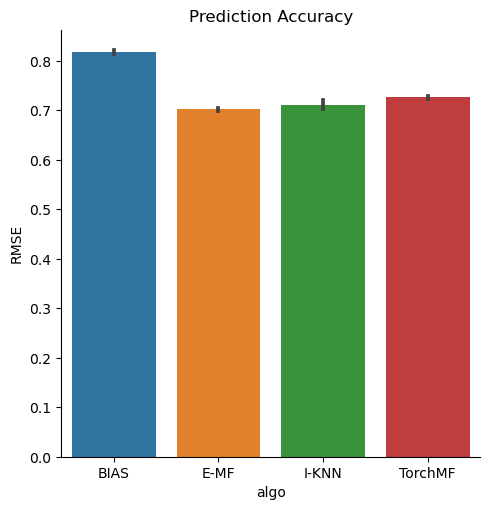

In [25]:
sns.catplot(user_rmse, x='algo', y='RMSE', kind='bar')
plt.title('Prediction Accuracy')
plt.show()

### Statistical Inference

We have these metrics, how do we do inference on them?  The confidence intervals indicate some significance, but we haven't taken into account the **non-independence** of measurements: each RMSE depends on the user across different algorithms!

For testing *two* algorithms, we can use a paired t-test:

In [40]:
rmse_wide = user_rmse.pivot(index='user', columns='algo', values='RMSE')
rmse_wide.head()

algo,BIAS,E-MF,I-KNN,TorchMF
user,,,,
1,0.103506,0.034663,NaN,0.071665
2,0.564070,0.535744,NaN,0.392388
3,0.064554,0.113213,NaN,0.120022
4,0.337112,0.660115,NaN,0.428752
5,1.986790,2.501450,2.546303,2.276736


In [41]:
ttest_rel(rmse_wide['BIAS'], rmse_wide['TorchMF'])

TtestResult(statistic=73.6390452928533, pvalue=0.0, df=138492)

Now, we have a very large sample size. We are always very likely to find significance!

For testing multiple ones at the same time, we effectively have a **repeated-measures** problem: each algorithm is measured multiple times, once for each algorithm.  We could use repeated-measures ANOVA, but this doesn't work if measures are missing for any elements, which is the case if we don't get recommendations or predictions for a user.

The geneal solution is a **mixed-effects model**.

- With 2 levels of our experiment variable, it is equivalent to a paired T-test
- With complete data (every user-algo pair is observed), it is equivalent to a repeated-measures ANOVA

Statsmodels provides this.

We need our **exogenous** variables (in statsmodels terms), which are:

- all but 1 algorithm (we will use `Bias` as our baseline)

We aren't going to bother with a global intercept - we will let the per-user intercept take care of that.

In [43]:
rmse_algos = pd.get_dummies(user_rmse['algo']).drop(columns=['BIAS'])
rmse_algos

,E-MF,I-KNN,TorchMF
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0
...,...,...,...
443173,0,0,1
443174,0,0,1
443175,0,0,1
443176,0,0,1


In [55]:
rmse_lm = sm.MixedLM(np.log(user_rmse['RMSE']), rmse_algos, user_rmse['user'])
rmse_fit = rmse_lm.fit()
rmse_fit.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
          Mixed Linear Model Regression Results
==========================================================
Model:            MixedLM Dependent Variable: RMSE        
No. Observations: 443178  Method:             REML        
No. Groups:       138493  Scale:              0.1395      
Min. group size:  3       Log-Likelihood:     -408569.6856
Max. group size:  4       Converged:          Yes         
Mean group size:  3.2                                     
----------------------------------------------------------
              Coef.  Std.Err.    z     P>|z| [0.025 0.975]
----------------------------------------------------------
E-MF          -0.244    0.001 -173.410 0.000 -0.247 -0.241
I-KNN         -0.229    0.003  -84.677 0.000 -0.234 -0.223
TorchMF       -0.190    0.001 -135.159 0.000 -0.193 -0.188
Group Var      0.952    0.013                             
==========================================================

"""

In [50]:
rmse_resid = rmse_fit.resid

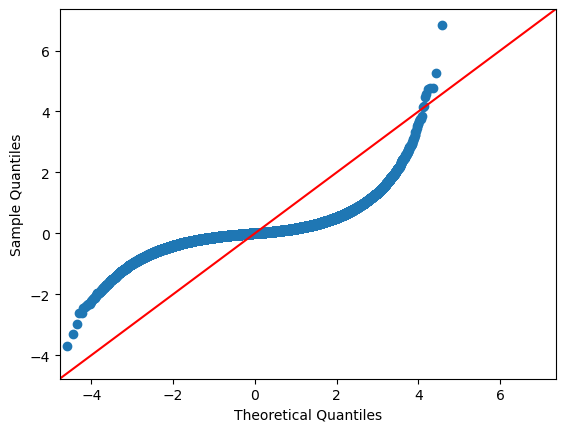

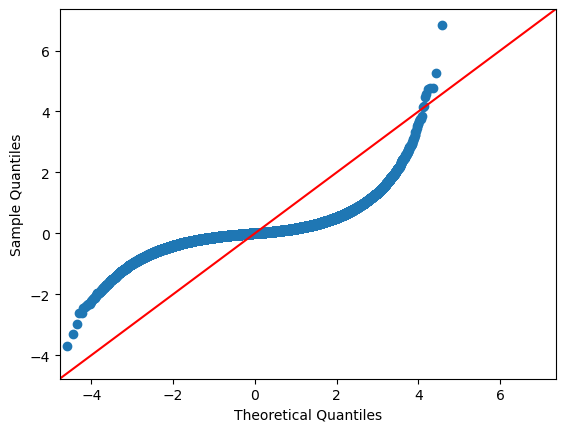

In [54]:
sm.qqplot(rmse_resid, line='45', scale=True)

## Recommendation Utility

Now let's evaluate the top-*N* recommendations.

In [26]:
rla = topn.RecListAnalysis()
rla.add_metric(topn.hit, k=20)
rla.add_metric(topn.recip_rank, k=20)
rla.add_metric(topn.ndcg, k=20)
user_scores = rla.compute(recs, test_ratings)
user_scores.reset_index(inplace=True)
user_scores

[   INFO] lenskit.topn analyzing 8863560 recommendations (692465 truth rows)
[   INFO] lenskit.topn using rec key columns ['algo', 'part', 'user']
[   INFO] lenskit.topn using truth key columns ['part', 'user']
[   INFO] lenskit.topn numbering truth lists
[   INFO] lenskit.topn numbering rec lists
[   INFO] lenskit.topn collecting metric results
[   INFO] lenskit.topn measured 443178 lists in 6.31s


,algo,part,user,nrecs,hit,recip_rank,ndcg
0,TorchMF,0,5,20,1.0,1.0,0.582017
1,TorchMF,0,11,20,1.0,0.1,0.096291
2,TorchMF,0,15,20,0.0,0.0,0.000000
3,TorchMF,0,17,20,0.0,0.0,0.000000
4,TorchMF,0,19,20,0.0,0.0,0.000000
...,...,...,...,...,...,...,...
443173,I-KNN,0,138487,20,0.0,0.0,0.000000
443174,I-KNN,0,138488,20,0.0,0.0,0.000000
443175,I-KNN,0,138489,20,0.0,0.0,0.000000
443176,I-KNN,0,138492,20,0.0,0.0,0.000000


In [27]:
us_tall = user_scores.melt(id_vars=['algo', 'user'], value_vars=['recip_rank', 'hit', 'ndcg'], var_name='Metric')
us_tall

,algo,user,Metric,value
0,TorchMF,5,recip_rank,1.0
1,TorchMF,11,recip_rank,0.1
2,TorchMF,15,recip_rank,0.0
3,TorchMF,17,recip_rank,0.0
4,TorchMF,19,recip_rank,0.0
...,...,...,...,...
1329529,I-KNN,138487,ndcg,0.0
1329530,I-KNN,138488,ndcg,0.0
1329531,I-KNN,138489,ndcg,0.0
1329532,I-KNN,138492,ndcg,0.0


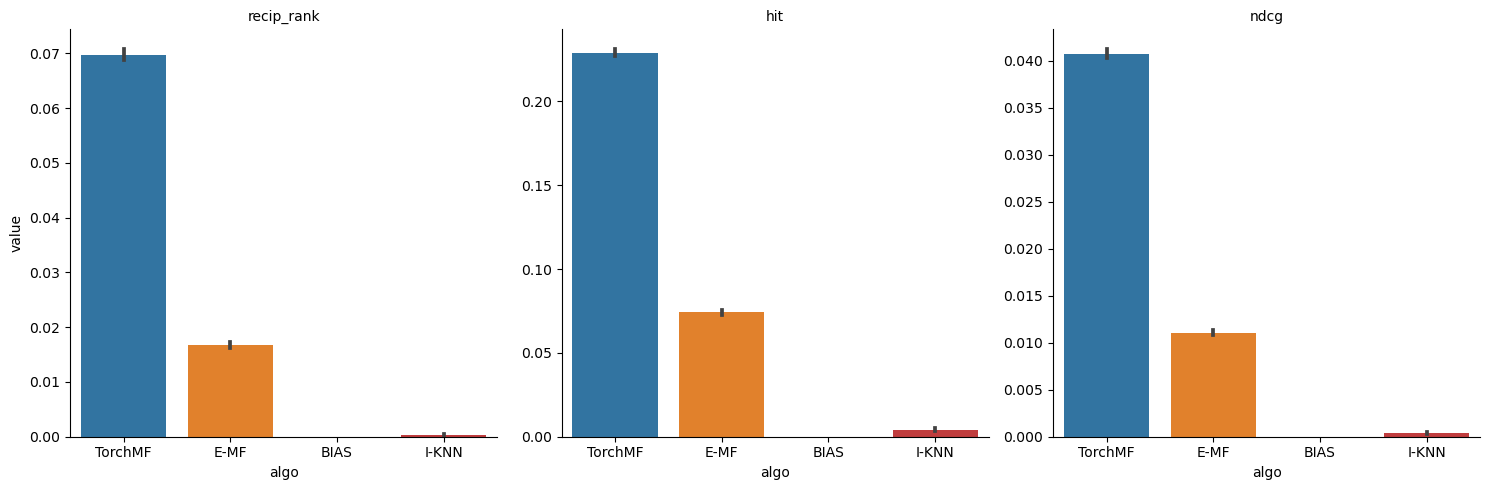

In [28]:
g = sns.catplot(us_tall, x='algo', y='value', col='Metric', kind='bar', sharey=False)
g.set_titles('{col_name}')
g.set_xlabels(None)
plt.show()